### Análisis Exploratorio, Comparativo y Contraste de Hipótesis

In [68]:
import pandas as pd
import numpy as np

pd.options.mode.copy_on_write = True # CoW por defecto a partir de Pandas 3.0.0

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import kruskal


In [69]:
# Carga de datasets limpios
# se desactiva low_memory para evitar warnings por tipos mixtos)

licencias = pd.read_csv(
    "./datasets/Licencias_2024y2025_limpio.csv",
    parse_dates=["fechanacimiento", "fechaaltasolicitud"],
    low_memory=False
)


In [70]:
siniestros = pd.read_csv(
    "./datasets/Siniestros_limpio.csv",
    parse_dates=["fechaparteaccidente", "fechaaltaparte"],
    low_memory=False
)


In [71]:
licencias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18915 entries, 0 to 18914
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   nif                            18915 non-null  object        
 1   nombre                         18915 non-null  object        
 2   apellido1                      18915 non-null  object        
 3   apellido2                      18896 non-null  object        
 4   sexo                           18915 non-null  object        
 5   fechanacimiento                18915 non-null  datetime64[ns]
 6   poblaciondomicilio             18915 non-null  object        
 7   descripcionprovinciadomicilio  18915 non-null  object        
 8   codigopostaldomicilio          18915 non-null  object        
 9   telefono1                      18914 non-null  object        
 10  telefono2                      4962 non-null   object        
 11  email          

In [72]:
siniestros.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   nif                    631 non-null    object        
 1   nombre                 631 non-null    object        
 2   apellido1              631 non-null    object        
 3   apellido2              630 non-null    object        
 4   fechaparteaccidente    631 non-null    datetime64[ns]
 5   fechaaltaparte         631 non-null    datetime64[ns]
 6   codigo                 631 non-null    int64         
 7   descripcionparte       631 non-null    object        
 8   actividad              631 non-null    object        
 9   lugar                  631 non-null    object        
 10  fecharecepcion         631 non-null    object        
 11  centrourgencias        257 non-null    object        
 12  macizomontañoso        628 non-null    object        
 13  nombr

### Creación del dataset analítico

In [73]:
df_analisis = siniestros.merge(
    licencias[
        [
            "nif",
            "modalidad",   # ← tipo de seguro
            "sexo",
            "edad",
            "categoria",
            "temporada"
        ]
    ],
    on="nif",
    how="left"
)


In [74]:
df_analisis.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   nif                    631 non-null    object        
 1   nombre                 631 non-null    object        
 2   apellido1              631 non-null    object        
 3   apellido2              630 non-null    object        
 4   fechaparteaccidente    631 non-null    datetime64[ns]
 5   fechaaltaparte         631 non-null    datetime64[ns]
 6   codigo                 631 non-null    int64         
 7   descripcionparte       631 non-null    object        
 8   actividad              631 non-null    object        
 9   lugar                  631 non-null    object        
 10  fecharecepcion         631 non-null    object        
 11  centrourgencias        257 non-null    object        
 12  macizomontañoso        628 non-null    object        
 13  nombr

### Limpieza analítica focalizada


In [75]:
# Eliminación de nulos SOLO en variables clave

df_analisis = df_analisis.dropna(
    subset=["modalidad", "descripciongrado"]
)


In [76]:
df_analisis.isnull().sum()


nif                        0
nombre                     0
apellido1                  0
apellido2                  1
fechaparteaccidente        0
fechaaltaparte             0
codigo                     0
descripcionparte           0
actividad                  0
lugar                      0
fecharecepcion             0
centrourgencias          374
macizomontañoso            3
nombreparaje               3
entrenamiento              0
actividadpersonal          0
actividadorganizada        0
festivo                    0
nresponsables              0
tamañogrupo                0
centrohospitalizacion    576
descripciongrado           0
pais                       0
provincia                  0
tipoaccidente              0
modalidad                  0
sexo                       0
edad                       0
categoria                  0
temporada                  0
dtype: int64

### Tratamiento de valores nulos en el dataset analítico

La eliminación de valores nulos se realizó de forma selectiva, atendiendo
exclusivamente a las variables directamente implicadas en las hipótesis
planteadas.

En concreto, se eliminaron únicamente los registros con valores nulos en:

- `modalidad`, variable explicativa principal (tipo de seguro).
- `descripciongrado`, variable respuesta que mide la gravedad del accidente.

Esta decisión se adopta para garantizar la validez del análisis comparativo
y de los contrastes estadísticos, evitando al mismo tiempo una pérdida
innecesaria de información en variables no críticas para los objetivos
del estudio.

Los valores nulos en otras variables se conservaron al no interferir
en la respuesta a la pregunta de investigación.


### Análisis UNIVARIANTE

#### Distribución de siniestros por tipo de seguro (modalidad)

In [77]:
df_analisis["modalidad"].value_counts()


modalidad
B     481
C      95
D      26
A      16
AU      5
B6      4
A6      3
OT      1
Name: count, dtype: int64

In [78]:
df_analisis["modalidad"].value_counts(normalize=True) * 100


modalidad
B     76.228209
C     15.055468
D      4.120444
A      2.535658
AU     0.792393
B6     0.633914
A6     0.475436
OT     0.158479
Name: proportion, dtype: float64

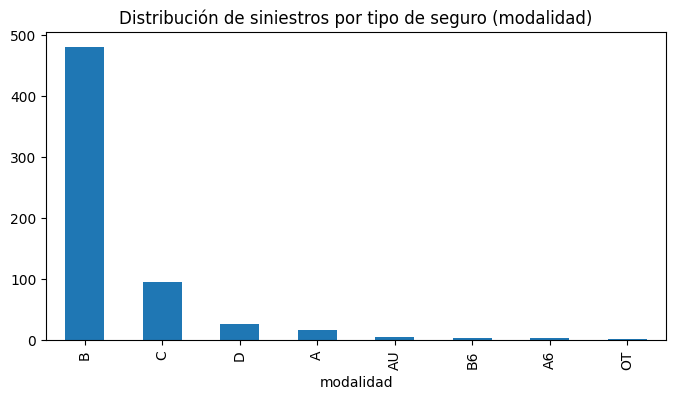

In [79]:
df_analisis["modalidad"].value_counts().plot(
    kind="bar",
    figsize=(8,4),
    title="Distribución de siniestros por tipo de seguro (modalidad)"
)
plt.show()


**Distribución de seguros por modalidad**

La distribución de seguros por modalidad muestra un claro predominio de la
modalidad B, que concentra la mayor parte de las pólizas registradas en el
dataset. A una distancia considerable se sitúa la modalidad C, mientras que
las modalidades D y A presentan una presencia mucho más reducida.

Las modalidades AU, B6, A6 y OT tienen una representación marginal, lo que
indica que se trata de productos poco frecuentes o específicos dentro del
conjunto analizado.

Esta distribución refleja una fuerte concentración de los asegurados en
un número reducido de modalidades, aspecto relevante a tener en cuenta en
los análisis comparativos posteriores, ya que las modalidades minoritarias
pueden no contar con suficiente volumen para extraer conclusiones robustas.


#### Distribución de la gravedad del accidente

In [80]:
df_analisis["descripciongrado"].value_counts()


descripciongrado
LEVE      526
GRAVE      57
NAN        42
MORTAL      6
Name: count, dtype: int64

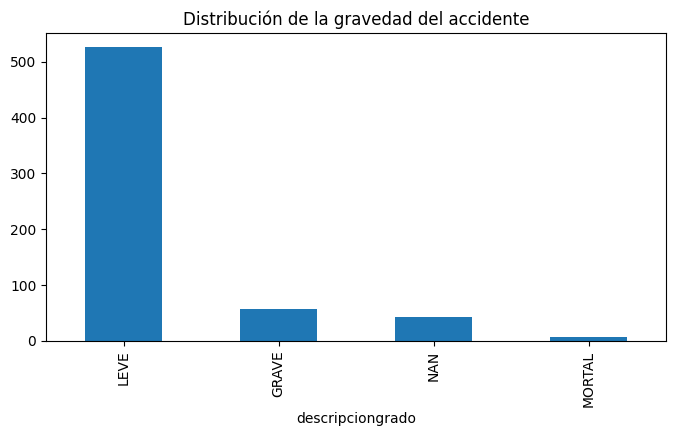

In [81]:
df_analisis["descripciongrado"].value_counts().plot(
    kind="bar",
    figsize=(8,4),
    title="Distribución de la gravedad del accidente"
)
plt.show()


**Análisis de la gravedad de los siniestros**

La distribución de la gravedad de los siniestros muestra un claro predominio
de los accidentes leves, que representan la gran mayoría de los casos
registrados en el dataset.

Los accidentes graves constituyen una proporción significativamente menor,
mientras que los accidentes mortales son muy poco frecuentes. La categoría
NAN corresponde a registros en los que no se dispone de información sobre
el grado de gravedad del siniestro.

Esta distribución indica que, aunque la ocurrencia de siniestros es elevada,
la mayor parte de ellos no presenta consecuencias de alta gravedad, si bien
la presencia de valores sin clasificar debe tenerse en cuenta en los
análisis posteriores.


### Análisis BIVARIANTE

#### Modalidad vs gravedad del accidente

In [95]:
# Tabla de contingencia: modalidad vs gravedad del accidente
tabla_modalidad_gravedad = pd.crosstab(
    df_analisis["modalidad"],
    df_analisis["descripciongrado"]
)

tabla_modalidad_gravedad




descripciongrado,GRAVE,LEVE,MORTAL,NAN
modalidad,,,,
A,3,11,0,2
A6,0,3,0,0
AU,0,4,0,1
B,40,406,6,29
B6,0,4,0,0
C,6,81,0,8
D,8,16,0,2
OT,0,1,0,0


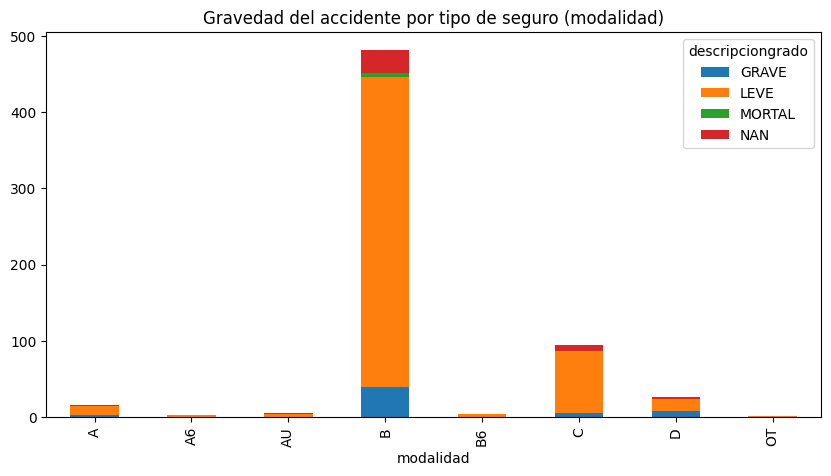

In [83]:
tabla_modalidad_gravedad.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title="Gravedad del accidente por tipo de seguro (modalidad)"
)
plt.show()


**Conclusión**

La tabla de contingencia muestra que la mayoría de los siniestros, con independencia de la modalidad deportiva, corresponden a accidentes de carácter leve.

La modalidad B concentra el mayor número absoluto de siniestros, así como la mayor cantidad de accidentes graves y mortales, lo que es coherente con su mayor volumen de registros en el dataset.

No se observan patrones claros que indiquen que determinadas modalidades presenten una proporción significativamente mayor de accidentes graves o mortales respecto al resto, más allá de las diferencias derivadas del tamaño muestral de cada modalidad.

### Indicador clave
#### Tasa de siniestralidad por modalidad

In [84]:
federados_por_modalidad = licencias.groupby("modalidad")["nif"].nunique()
siniestros_por_modalidad = df_analisis.groupby("modalidad")["nif"].count()

tasa_siniestralidad = (
    siniestros_por_modalidad / federados_por_modalidad * 1000
).dropna()

tasa_siniestralidad.sort_values(ascending=False)


modalidad
D     79.027356
C     62.789161
B     34.376787
A6    23.437500
B6    17.391304
AU     8.605852
A      8.255934
OT     5.235602
Name: nif, dtype: float64

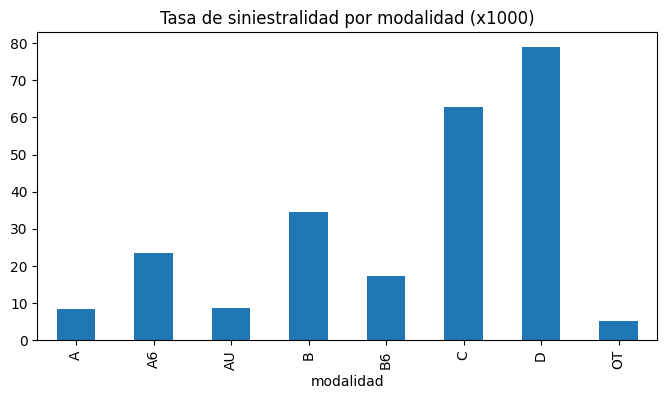

In [85]:
tasa_siniestralidad.plot(
    kind="bar",
    figsize=(8,4),
    title="Tasa de siniestralidad por modalidad (x1000)"
)
plt.show()


**Conclusión**

La siniestralidad se concentra principalmente en las modalidades D (79%) y C (63%), 
mientras que las modalidades AU, A y OT presentan los valores más bajos (<9%). 
Esto indica un riesgo significativamente mayor en D y C, que deberían priorizarse para análisis y medidas preventivas.

### Contraste de hipótesis

### Hipótesis A

#### ¿Existen diferencias significativas en la frecuencia/gravedad de los siniestros según la modalidad?

##### Test Chi-cuadrado

In [86]:
chi2, p_valor, _, _ = chi2_contingency(tabla_modalidad_gravedad)

chi2, p_valor


(np.float64(25.100232553239024), np.float64(0.24284902642667566))

**Interpretación**

El test Chi-cuadrado arroja un p-value = 0.243, superior al nivel de
significación habitual (α = 0.05), por lo que no se rechaza la hipótesis
nula de independencia.

No se encuentra evidencia estadísticamente significativa de que la
frecuencia de siniestros dependa del tipo de seguro contratado.


### Hipótesis B

#### ¿Difiere la gravedad media del accidente según la modalidad?

#### Test Kruskal-Wallis

In [87]:
grupos_gravedad = [
    grupo["descripciongrado"].dropna()
    for _, grupo in df_analisis.groupby("modalidad")
]

kruskal(*grupos_gravedad)


KruskalResult(statistic=np.float64(9.79625638331725), pvalue=np.float64(0.20041645007998718))

**Interpretación**

El test de Kruskal-Wallis arroja un p-value = 0.200, superior al nivel
de significación (α = 0.05), por lo que no se rechaza la hipótesis nula.

No se detectan diferencias estadísticamente significativas en la gravedad
de los siniestros entre los distintos tipos de seguro.


### Hipótesis C
#### Análisis temporal de los siniestros

In [88]:
# Extraer mes numérico desde la fecha del accidente
df_analisis["mes"] = df_analisis["fechaparteaccidente"].dt.month

# Diccionario de meses en español
meses_es = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

# Crear columna con nombre del mes
df_analisis["mes_nombre"] = df_analisis["mes"].map(meses_es)

# Orden cronológico correcto
orden_meses = [
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
]

df_analisis["mes_nombre"] = pd.Categorical(
    df_analisis["mes_nombre"],
    categories=orden_meses,
    ordered=True
)


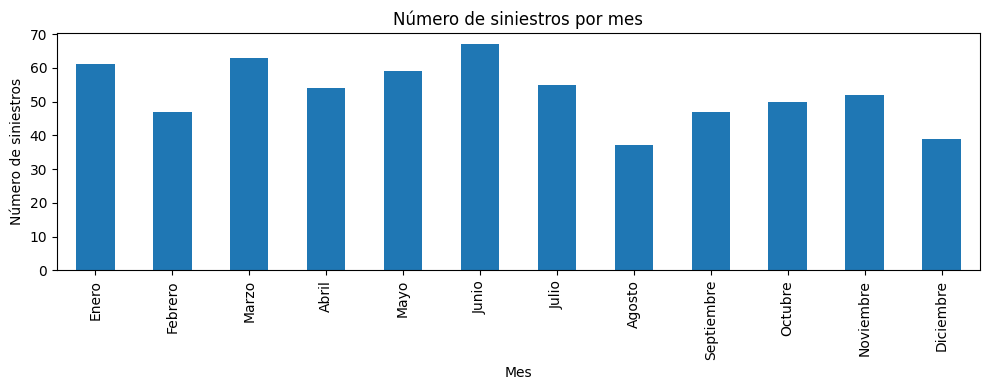

In [91]:
siniestros_por_mes = (
    df_analisis
    .groupby("mes_nombre", observed=True)["nif"]
    .count()
)

siniestros_por_mes.plot(
    kind="bar",
    figsize=(10, 4),
    title="Número de siniestros por mes",
    xlabel="Mes",
    ylabel="Número de siniestros"
)

plt.tight_layout()
plt.show()


**Conclusión**

El análisis descriptivo por mes muestra que la distribución de los
siniestros no es homogénea a lo largo del año, observándose una mayor
concentración de accidentes en determinados meses.

Este patrón sugiere la existencia de un componente estacional en la
ocurrencia de siniestros, posiblemente relacionado con factores como
la climatología, la mayor actividad deportiva en ciertos periodos
o el calendario vacacional.
